In [128]:
# 库模块导入
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [129]:
MAX_WORD = 10000  # 只保留最高频的10000词
MAX_LEN = 300     # 句子统一长度为300
word_count={}     # 词典，统计词出现的词数

In [131]:

#清理文本，去标点符号，转小写
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9]", " ", string)
    string = re.sub(r"<br", " ", string)
    string = re.sub(r"/>", " ", string)
    string = re.sub(r"\'", " \'", string)

    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

# 分词方法
def tokenizer(sentence):
    return sentence.split()

#  数据预处理过程
def data_process(text_path, text_dir): # 根据文本路径生成文本的标签

    print("data preprocess")
    # 打开新文档，预处理后text添加入该文档
    file_pro = open(text_path,'w',encoding='utf-8')

    file_tag = ['pos', 'neg'] # 只使用pos和neg中文件
    for tag in file_tag:

      f_path = os.path.join(text_dir, tag)

      # 得到Label
      if tag == 'pos':
        label = '1'
      elif tag == 'neg':
        label = '0'

      # 遍历文件夹中文件
      for file_name in os.listdir(f_path):
        # 判断是否为txt文件
        if not file_name.endswith('txt'):
          continue
        file_path = os.path.join(f_path, file_name)
        # 打开文本
        f = open(file_path, 'r', encoding='utf-8')
        # 清理文本
        clean_text = clean_str(f.readline())
        # 分割文本
        tokens = clean_text.split()
        # 统计词频
        for token in tokens:
          if token in word_count.keys():
            word_count[token] += 1
          else:
            word_count[token] = 1
        file_pro.write(label + ' ' + clean_text +'\n')
        f.close()
        file_pro.flush()

    file_pro.close()
    print("build vocabulary")

    vocab = {"<UNK>": 0, "<PAD>": 1}

    word_count_sort = sorted(word_count.items(), key=lambda item : item[1], reverse=True) # 对词进行排序，过滤低频词，只取前MAX_WORD个高频词
    word_number = 1
    for word in word_count_sort:
        if word[0] not in vocab.keys():
            vocab[word[0]] = len(vocab)
            word_number += 1
        if word_number > MAX_WORD:
            break
    return vocab


In [132]:
# 定义Dataset
class MyDataset(Dataset):
    def __init__(self, text_path):
      file = open(text_path, 'r', encoding='utf-8')
      self.text_with_tag = file.readlines()  # 文本标签与内容
      file.close()

    # 重写getitem
    def __getitem__(self, index):
      # 获取一个样本的标签和文本信息
      line = self.text_with_tag[index]
      label = int(line[0]) # 标签信息
      text = line[2:-1]  # 文本信息
      return text, label

    def __len__(self):
      return len(self.text_with_tag)

In [133]:
# 根据vocab将句子转为定长MAX_LEN的tensor
def text_transform(sentence_list, vocab):
    sentence_index_list = []
    for sentence in sentence_list:
        sentence_idx = [vocab[token] if token in vocab.keys() else vocab['<UNK>'] for token in tokenizer(sentence)] # 句子分词转为id

        if len(sentence_idx) < MAX_LEN:
            for i in range(MAX_LEN-len(sentence_idx)): # 对长度不够的句子进行PAD填充
                sentence_idx.append(vocab['<PAD>'])

        sentence_idx = sentence_idx[:MAX_LEN] # 取前MAX_LEN长度
        sentence_index_list.append(sentence_idx)
    return torch.LongTensor(sentence_index_list) # 将转为idx的词转为tensor

In [134]:
# 定义LSTM模型
class LSTM(nn.Module):
    def __init__(self, vocab, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        # embedding层
        self.embedding = nn.Embedding(len(vocab), input_size)
        # LSTM层
        self.lstm = nn.LSTM(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=num_layers,
                   bidirectional=False)
        # 全连接层
        self.fc = nn.Linear(hidden_size, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.permute(1,0)) # permute(1,0)交换维度
        outputs, _ = self.lstm(embeddings)
        encoding = outputs[-1]
        outs = self.softmax(self.fc(encoding)) # 输出层为二维概率[a,b]
        return outs

In [135]:
# 定义绘制loss曲线函数
def DrawLoss(file_name, label_name):

    with open(file_name, 'r') as f:
        raw_data = f.read()
        # [-1:1]是为了去除文件中的前后中括号"[]"
        data = raw_data[1:-1].split(",")

    y_loss = np.asfarray(data, float)
    x_loss = range(len(y_loss))
    plt.figure()

    # 去除顶部和右侧边框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('iters')    # x轴标签
    plt.ylabel('loss')     # y轴标签

    # 以x_loss为横坐标，y_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
    plt.plot(x_loss, y_loss, linewidth=1, linestyle="solid", label=label_name)
    plt.legend()
    plt.title('Loss curve')
    plt.show()

In [136]:
# 模型训练
def train(model, train_data, vocab, epoch=10):
    # 记录训练loss
    train_losses = []

    print('train model')
    model = model.to(device)
    loss_sigma = 0.0
    correct = 0.0
    # 定义损失函数和优化器
    criterion = torch.nn.NLLLoss()
    learning_rate = 0.005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(epoch)):
        model.train()
        avg_loss = 0  # 平均损失
        avg_acc = 0  # 平均准确率
        for idx, (text, label) in enumerate(tqdm(train_data)):

            train_x = text_transform(text, vocab).to(device)
            train_y = label.to(device)

            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred.log(), train_y)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            avg_acc += accuracy(pred, train_y)

            train_losses.append(loss.item())

        # 一个epoch结束后，计算平均loss和评平均acc
        avg_loss = avg_loss / len(train_data)
        avg_acc = avg_acc / len(train_data)

        print("avg_loss:", avg_loss, " train_avg_acc:,", avg_acc)

        # 保存训练完成后的模型参数
        torch.save(model.state_dict(), 'LSTM_IMDB_parameter.pkl')

    # 绘制train loss曲线
    file_name_train = 'train_logs.txt'
    with open(file_name_train,'w') as train_los:
        train_los.write(str(train_losses))
    DrawLoss(file_name_train, "train_loss")

In [137]:
# 计算预测准确性
def accuracy(y_pred, y_true):
    label_pred = y_pred.max(dim=1)[1]
    acc = len(y_pred) - torch.sum(torch.abs(label_pred-y_true)) # 正确的个数
    return acc.detach().cpu().numpy() / len(y_pred)

In [138]:
# 模型测试
def test(model, test_data, vocab):
    # 记录测试loss
    test_losses = []

    # 在每个类别上的正确数
    true = [0,0] # (pos, neg)
    false = [0,0]

    print('test model')
    model = model.to(device)
    model.eval()
    criterion = torch.nn.NLLLoss()
    avg_acc = 0
    for idx, (text, label) in enumerate(tqdm(test_data)):
        train_x = text_transform(text, vocab).to(device)
        train_y = label.to(device)
        pred = model(train_x)
        loss = criterion(pred.log(), train_y)
        test_losses.append(loss.item())

        avg_acc += accuracy(pred, train_y)

        pred_label = pred.max(dim=1)[1]
        # 预测为pos且真实为pos
        true[0] += torch.sum((pred_label == 1) & (train_y == 1)).item()
        # 预测为pos但真实为neg
        false[0] += torch.sum((pred_label == 1) & (train_y == 0)).item()
        # 预测为neg且真实为neg
        true[1] += torch.sum((pred_label == 0) & (train_y == 0)).item()
        # 预测为neg但真实为pos
        false[1] += torch.sum((pred_label == 0) & (train_y == 1)).item()

    # 绘制test loss曲线
    file_name_test = 'test_logs.txt'
    with open(file_name_test,'w') as test_los:
        test_los.write(str(test_losses))
    DrawLoss(file_name_test, "test_loss")

    # 总精度
    avg_accuracy = (true[0] + true[1]) / (false[0] + false[1] + true[0] + true[1])
    # 各类别精度
    pos_accuracy = true[0] / (true[0] + false[0])  # Adding a small value to avoid division by zero
    neg_accuracy = true[1] / (true[1] + false[1])

    # 整体精度
    print(f'Accuracy of all: {100 * avg_accuracy} %')
    # 各类别精度
    print(f'Accuracy of pos: {100 * pos_accuracy} %')
    print(f'Accuracy of neg: {100 * neg_accuracy} %')

    return avg_acc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data preprocess
build vocabulary
data preprocess
build vocabulary
train model


  2%|▏         | 1/50 [00:09<07:30,  9.20s/it]

avg_loss: 0.6964055397072617  train_avg_acc:, 0.5064515761661808



  4%|▍         | 2/50 [00:18<07:31,  9.40s/it]

avg_loss: 0.6693357648898144  train_avg_acc:, 0.5460474368318756



  6%|▌         | 3/50 [00:28<07:31,  9.61s/it]

avg_loss: 0.5809901849347718  train_avg_acc:, 0.654678389212828



  8%|▊         | 4/50 [00:38<07:20,  9.58s/it]

avg_loss: 0.4047896418036247  train_avg_acc:, 0.8283983236151603



 10%|█         | 5/50 [00:47<07:10,  9.56s/it]

avg_loss: 0.309263928508272  train_avg_acc:, 0.8772587159863946



 12%|█▏        | 6/50 [00:57<07:07,  9.71s/it]

avg_loss: 0.2951728021916078  train_avg_acc:, 0.8824898262876579



 14%|█▍        | 7/50 [01:07<06:59,  9.76s/it]

avg_loss: 0.23254533066433303  train_avg_acc:, 0.9110027939747327



 16%|█▌        | 8/50 [01:16<06:41,  9.55s/it]

avg_loss: 0.2181075793900052  train_avg_acc:, 0.9167349975704567



 18%|█▊        | 9/50 [01:26<06:36,  9.68s/it]

avg_loss: 0.18243513887329976  train_avg_acc:, 0.9323277301992225



 20%|██        | 10/50 [01:36<06:31,  9.80s/it]

avg_loss: 0.13166517422211413  train_avg_acc:, 0.95453337585034



 22%|██▏       | 11/50 [01:45<06:12,  9.56s/it]

avg_loss: 0.10500146996001808  train_avg_acc:, 0.964693801627794



 24%|██▍       | 12/50 [01:55<06:07,  9.66s/it]

avg_loss: 0.09458887067680456  train_avg_acc:, 0.9684652879008746



 26%|██▌       | 13/50 [02:06<06:13, 10.08s/it]

avg_loss: 0.07586639271859004  train_avg_acc:, 0.9764789844509233



 28%|██▊       | 14/50 [02:15<05:51,  9.78s/it]

avg_loss: 0.07225960527299619  train_avg_acc:, 0.9781549896744413



 30%|███       | 15/50 [02:25<05:44,  9.84s/it]

avg_loss: 0.05877144978742818  train_avg_acc:, 0.9832949921039845



 32%|███▏      | 16/50 [02:35<05:35,  9.88s/it]

avg_loss: 0.046628523190334746  train_avg_acc:, 0.9875428966229349



 34%|███▍      | 17/50 [02:44<05:17,  9.62s/it]

avg_loss: 0.0706139872021669  train_avg_acc:, 0.9785725674198251



 36%|███▌      | 18/50 [02:54<05:11,  9.73s/it]

avg_loss: 0.06930111734462636  train_avg_acc:, 0.9787111273080661



 38%|███▊      | 19/50 [03:04<05:04,  9.81s/it]

avg_loss: 0.06397263709531754  train_avg_acc:, 0.9804061133381925



 40%|████      | 20/50 [03:13<04:47,  9.58s/it]

avg_loss: 0.054248525323916455  train_avg_acc:, 0.983854925898931



 42%|████▏     | 21/50 [03:23<04:41,  9.72s/it]

avg_loss: 0.04801775222378118  train_avg_acc:, 0.9861231322886297



 44%|████▍     | 22/50 [03:33<04:35,  9.82s/it]

avg_loss: 0.03427744284747358  train_avg_acc:, 0.991367529154519



 46%|████▌     | 23/50 [03:43<04:20,  9.66s/it]

avg_loss: 0.038403238217365375  train_avg_acc:, 0.9896345815111759



 48%|████▊     | 24/50 [03:53<04:13,  9.75s/it]

avg_loss: 0.0419500009821994  train_avg_acc:, 0.9881578747570458



 50%|█████     | 25/50 [04:03<04:06,  9.86s/it]

avg_loss: 0.0566908766810155  train_avg_acc:, 0.9832570304907677



 52%|█████▏    | 26/50 [04:12<03:53,  9.74s/it]

avg_loss: 0.05978697794964727  train_avg_acc:, 0.9814823250728864



 54%|█████▍    | 27/50 [04:22<03:43,  9.73s/it]

avg_loss: 0.05811344718142432  train_avg_acc:, 0.9812792304421768



 56%|█████▌    | 28/50 [04:32<03:35,  9.79s/it]

avg_loss: 0.029023882823673134  train_avg_acc:, 0.992684797133139



 58%|█████▊    | 29/50 [04:41<03:23,  9.68s/it]

avg_loss: 0.021099308341722554  train_avg_acc:, 0.9953155369290574



 60%|██████    | 30/50 [04:51<03:14,  9.72s/it]

avg_loss: 0.017758041358913998  train_avg_acc:, 0.9959703747570458



 62%|██████▏   | 31/50 [05:02<03:11, 10.10s/it]

avg_loss: 0.016183776847485985  train_avg_acc:, 0.9964923469387755



 64%|██████▍   | 32/50 [05:12<03:00, 10.04s/it]

avg_loss: 0.020848136466490676  train_avg_acc:, 0.9946777818270165



 66%|██████▌   | 33/50 [05:21<02:46,  9.80s/it]

avg_loss: 0.025495440475832746  train_avg_acc:, 0.9923260598882411



 68%|██████▊   | 34/50 [05:31<02:37,  9.86s/it]

avg_loss: 0.035150146477722695  train_avg_acc:, 0.9893935252672498



 70%|███████   | 35/50 [05:41<02:28,  9.93s/it]

avg_loss: 0.02796325787464727  train_avg_acc:, 0.9919483418367347



 72%|███████▏  | 36/50 [05:50<02:15,  9.69s/it]

avg_loss: 0.020025779196175233  train_avg_acc:, 0.994915041909621



 74%|███████▍  | 37/50 [06:01<02:07,  9.82s/it]

avg_loss: 0.02231805413315187  train_avg_acc:, 0.9936812894800777



 76%|███████▌  | 38/50 [06:10<01:58,  9.87s/it]

avg_loss: 0.0181422501526849  train_avg_acc:, 0.9955546950923226



 78%|███████▊  | 39/50 [06:20<01:46,  9.67s/it]

avg_loss: 0.013317576487197027  train_avg_acc:, 0.9970902423469388



 80%|████████  | 40/50 [06:30<01:38,  9.84s/it]

avg_loss: 0.011052018815499484  train_avg_acc:, 0.9975875394800777



 82%|████████▏ | 41/50 [06:40<01:29,  9.94s/it]

avg_loss: 0.01021272693558748  train_avg_acc:, 0.9980867346938775



 84%|████████▍ | 42/50 [06:49<01:18,  9.77s/it]

avg_loss: 0.012559118322500656  train_avg_acc:, 0.9969099246841594



 86%|████████▌ | 43/50 [06:59<01:08,  9.82s/it]

avg_loss: 0.01324110400889126  train_avg_acc:, 0.9969896440719145



 88%|████████▊ | 44/50 [07:10<00:59,  9.95s/it]

avg_loss: 0.024400017858596936  train_avg_acc:, 0.9932807944606414



 90%|█████████ | 45/50 [07:19<00:49,  9.82s/it]

avg_loss: 0.017379458621857042  train_avg_acc:, 0.9955755739795918



 92%|█████████▏| 46/50 [07:29<00:39,  9.82s/it]

avg_loss: 0.01938876164340585  train_avg_acc:, 0.9945392219387755



 94%|█████████▍| 47/50 [07:39<00:29,  9.95s/it]

avg_loss: 0.015393853580759724  train_avg_acc:, 0.9956135355928086



 96%|█████████▌| 48/50 [07:50<00:20, 10.22s/it]

avg_loss: 0.013018725739259805  train_avg_acc:, 0.9966309068270165



 98%|█████████▊| 49/50 [07:59<00:09,  9.97s/it]

avg_loss: 0.012397079362667032  train_avg_acc:, 0.996452487244898



100%|██████████| 50/50 [08:10<00:00,  9.80s/it]


avg_loss: 0.010658482962159668  train_avg_acc:, 0.99738824101069


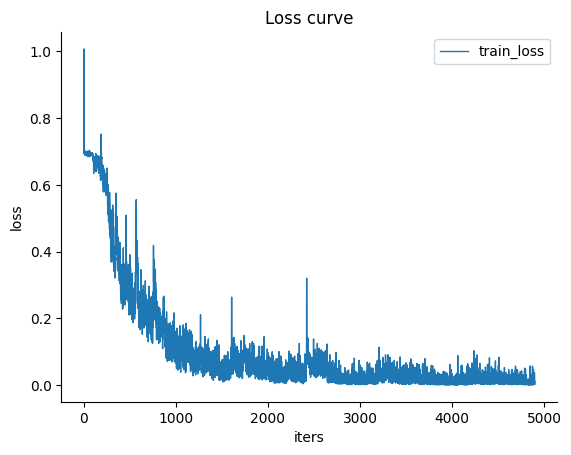

test model


100%|██████████| 391/391 [00:05<00:00, 73.29it/s]


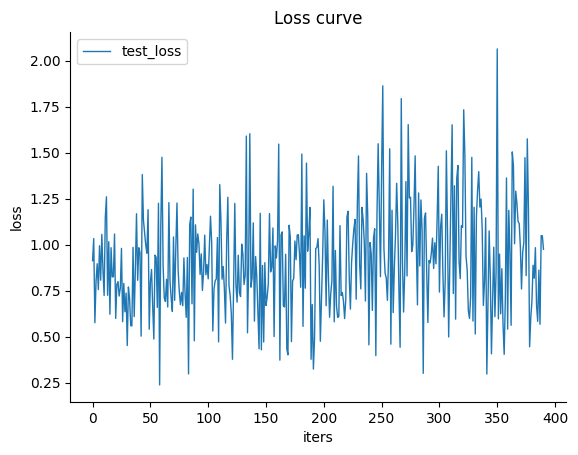

Accuracy of all: 82.788 %
Accuracy of pos: 82.47880180679927 %
Accuracy of neg: 83.10314191099265 %
323.7


In [139]:
# 主函数

def main():

    # 加载云端硬盘
    from google.colab import drive
    drive.mount('/content/drive')

    train_dir = '/content/drive/MyDrive/Colab Notebooks/aclImdb_v1/aclImdb/train'  # 原训练集文件地址
    train_path = '/content/drive/MyDrive/Colab Notebooks/train.txt'  # 预处理后的训练集文件地址

    test_dir = '/content/drive/MyDrive/Colab Notebooks/aclImdb_v1/aclImdb/test'  # 原训练集文件地址
    test_path = '/content/drive/MyDrive/Colab Notebooks/test.txt'  # 预处理后的训练集文件地址

    vocab = data_process(train_path, train_dir) # 数据预处理
    data_process(test_path, test_dir)

    # 词典保存为本地
    np.save('vocab.npy', vocab)
    # 加载本地已经存储的vocab
    vocab = np.load('vocab.npy', allow_pickle=True).item()

    # 构建MyDataset实例
    train_data = MyDataset(text_path=train_path)
    test_data = MyDataset(text_path=test_path)

    # 构建DataLoder
    train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

    # 生成模型
    model = LSTM(vocab=vocab, input_size=300, hidden_size=128, num_layers=2)  # 定义模型

    train(model=model, train_data=train_loader, vocab=vocab, epoch=50)

    # 加载训练好的模型
    model.load_state_dict(torch.load('LSTM_IMDB_parameter.pkl', map_location=torch.device('cpu')))

    # 测试结果
    acc = test(model=model, test_data=test_loader, vocab=vocab)
    print(acc)

if __name__ == '__main__':
    main()

